In [204]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

In [102]:
def phi(x):
    # simple plain wave in unit box
    return np.exp(1.0j * np.pi * x)

def position(distribution):
    # drawing points from custom distribution with rejection method (monte carlo-like sampling)
    while True:
        x = np.random.random_sample(1)
        y = np.random.uniform( low=0., high = 2.5 )
        if distribution(x) > 2.5:
            raise Exception("Check density normalization.")
        if y < distribution(x):
            return x

class State():
    def __init__(self, state, N_total, N_measured):
        # number of atoms in system at the beginning of experiment and number of annihilated atoms 
        self.N_total = N_total
        self.N_measured = N_measured
        self.vector = state
        
        # determining number of atoms in both condensates after N_measured annihilations ie. the basis vectors  |L,R>
        if N_measured <= N_total//2 + 1:
            # example: N_total = 10 atoms, N_measured = 3 measurements, then we expect basis |2,5>, |3,4>, |4,3>, |5,2>
            self.L = np.arange(N_total//2 - N_measured, N_total//2 + 1)
            self.R = np.arange(N_total//2, N_total//2 - N_measured - 1, step=-1)
        else:
            # example: N_total = 10 atoms, N_measured = 8 measurements, then we expect basis |0,2>, |1,1>, |2,0>
            self.L = np.arange(0, N_total - N_measured + 1)
            self.R = np.arange(N_total - N_measured, -1, step=-1)

    def next_state(self, phi, position):
        # 2 cases: 
        # N_measured smaller than half of total number of atoms - increasing number of basis states
        if self.N_measured < self.N_total//2 + 1:
            next_state = np.zeros(len(self.L)+1, dtype=np.complex128)
            next_state[:-1] += self.vector * phi(position) * np.sqrt(self.L)
            next_state[1:] += self.vector * phi(position).conj() * np.sqrt(self.R) 

        # or N_measured larger than half of total number of atoms - decreasing number of basis states
        else:
            next_state = np.zeros(len(self.L)-1, dtype=np.complex128)
            next_state += self.vector[1:] * phi(position) * np.sqrt(self.L[1:])
            next_state += self.vector[:-1] * phi(position).conj() * np.sqrt(self.R[:-1]) 

        return next_state
    
    def normalize(self):
        # normalize current state
        self.vector /= np.linalg.norm(self.vector)

    def update_vector_size(self, size):
        # change state size to fit next iteration of desired size
        self.vector = np.zeros(size)

    def update_basis_size(self, size):
        # updating size of L and R basis 
        if size <= self.N_total//2 + 1:
            self.L = np.arange(self.N_total//2 - self.N_measured, self.N_total//2 + 1)
            self.R = np.arange(self.N_total//2, self.N_total//2 - self.N_measured - 1, step=-1)
        else:
            self.L = np.arange(0, self.N_total - self.N_measured + 1)
            self.R = np.arange(self.N_total - self.N_measured, -1, step=-1)

    def density(self, phi):
        # <state*| phi* phi |state>, normalized
        return lambda x: ( self.next_state(phi, x) @ self.next_state(phi, x).conj() ) / (self.N_total - self.N_measured)
    
    def print(self, array):
        # column printer
        for i in range(len(array)):
            print(array[i])


In [245]:
# starting constants
N = 30000
state = State(np.array([1.]), N, 0)
sampled_positions = []
sampled_densities = []
control = [0,1,2,4,5,10,100,1000,10000, N]

for i in range(0, N):
    print("iteration: ", state.N_measured)

    # sample position of i-th atom from current one-particle probability density
    x = position(state.density(phi))
    sampled_positions.append(x[0])

    # check densities at control timesteps
    if i in control:
        points = [state.density(phi)(k) for k in np.arange(0, 1, 0.02)]
        sampled_densities.append(np.real(points))

    # update measured counter
    state.N_measured += 1

    # collapse system state after measuring single atom 
    next_vector = state.next_state(phi, x)

    # prepare state and basis size for next measurement
    # before any measurements (N_measured = 0) we have only one basis vector, thus argument of update
    state.update_vector_size(state.N_measured + 1)
    state.update_basis_size(state.N_measured + 1)

    state.vector = next_vector
    state.normalize()
    

    

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
itera

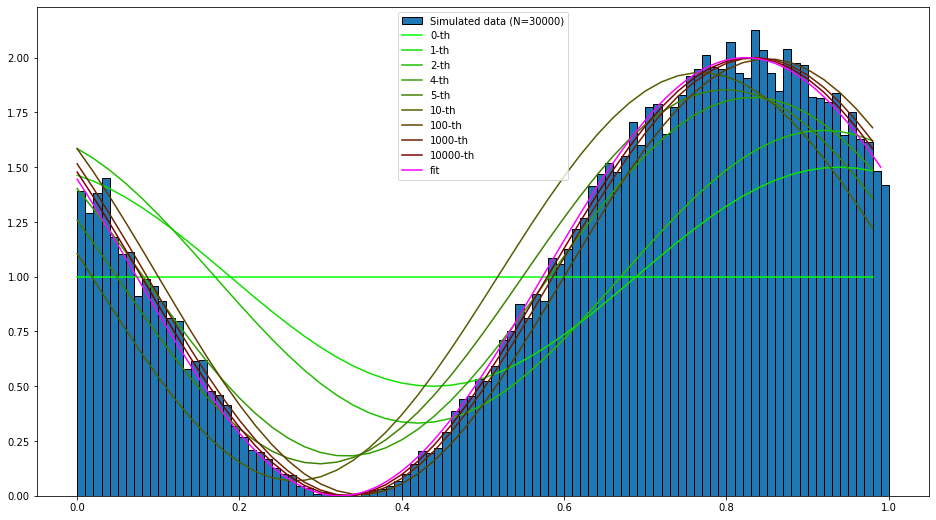

In [246]:
# colors for every plotted probability density function, arranged in gradient towards better fits
colors = [(k/2, 1-k, 0) for k in np.linspace(0, 1, len(sampled_densities))]

# enlarge plot for better quality
plt.figure(figsize=(16,9))

# histogram of measured positions of atoms
counts, bins, _ = plt.hist(sampled_positions,100,density=True,ec='k',label="Simulated data (N=%i)"%N) 

# probability density lines for corresponding measurements
for i in range(len(sampled_densities)):
    plt.plot(np.arange(0, 1, 0.02), sampled_densities[i], label="%d-th" % control[i], color = colors[i])

# best fit of function |phi(x) + exp(i*phase)*phi(x).conj()|^2
func = lambda x, f: np.real( (phi(x) + np.exp(1.j * f) * phi(x).conj()) * (phi(x).conj() + np.exp(-1.j * f) * phi(x)) ) / 2
f, _ = scipy.optimize.curve_fit(func, bins[:-1], counts)

plt.plot(bins[:-1], func(bins[:-1], f), label="fit", color='magenta')


plt.legend()
plt.show()